# Notebook

## Imports

In [71]:
import matplotlib.pyplot as plt
import math
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
%matplotlib inline
plt.rcParams['figure.dpi'] = 150

import importlib

# import local modules
if __name__ == '__main__' and __package__ is None:
    from os import sys, path
    sys.path.append(path.dirname(path.dirname(path.dirname(path.abspath("__file__")))))
import pytechsas.sensor.techsas_cross_compare as cc
import pytechsas.sensor.turn_filter as tf
from pytechsas.sensor.techsas_constant import *

In [72]:
def read_nvi(nav_file: str) -> xr.Dataset:
    """
    Creates xarray Dataset from a navigation file (.nvi).
    :param nav_file: inpout navigation file
    :return: Dataset with navigation data
    """
    with xr.open_dataset(nav_file) as ds:
        # get date as EPOCH
        datetime = pd.to_datetime((ds["mbDate"].data - 2440588) * 24 * 3600 * 1000 + ds["mbTime"].data, unit="ms")
        
        # use 'unwrap' method to get a correct interpolation of heading
        heading_unwrapped = ds["mbHeading"]
        heading_unwrapped[~np.isnan(heading_unwrapped)] = np.unwrap(
            heading_unwrapped[~np.isnan(heading_unwrapped)], period=360)
        ds["mbHeading"] = heading_unwrapped
        
        return xr.Dataset(
            data_vars={
                TECHSAS_LONGITUDE: ([TECHSAS_TIME], ds["mbAbscissa"].data, ds["mbAbscissa"].attrs),
                TECHSAS_LATITUDE: ([TECHSAS_TIME], ds["mbOrdinate"].data, ds["mbOrdinate"].attrs),
                TECHSAS_HEADING: ([TECHSAS_TIME], ds["mbHeading"].data, ds["mbHeading"].attrs),
                TECHSAS_SPEED: ([TECHSAS_TIME], ds["mbSpeed"].data, ds["mbSpeed"].attrs),
                TECHSAS_ALTITUDE: ([TECHSAS_TIME], ds["mbAltitude"].data, ds["mbAltitude"].attrs),
            },
            coords={TECHSAS_TIME: datetime},
        )

In [3]:
base_file = "F://04_globe_formation//sedymaq//nvi//output_merge.nvi"

In [80]:
nvi

<xarray.Dataset>
Dimensions:   (time: 13190)
Coordinates:
  * time      (time) datetime64[ns] 2012-06-07T06:36:35.003000064 ... 2012-06...
Data variables:
    lon       (time) float64 -1.504 -1.504 -1.504 ... -1.556 -1.556 -1.556
    lat       (time) float64 43.66 43.66 43.66 43.66 ... 43.65 43.65 43.65 43.65
    heading   (time) float64 271.0 271.0 270.9 270.9 ... 539.9 540.0 540.1 540.1
    speed     (time) float32 7.87 7.89 7.89 7.87 7.85 ... 4.3 4.3 4.28 4.26 4.24
    altitude  (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

[ True  True  True ...  True  True  True]


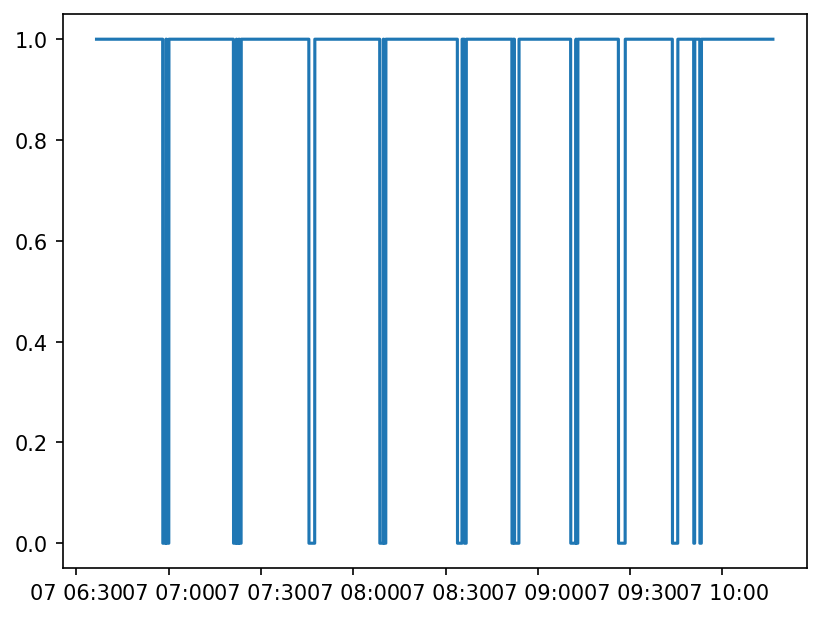

In [90]:
fig, ax = plt.subplots()
ax.plot(mask)
print(mask.values)

In [91]:
nvi.where(mask.values)

<xarray.Dataset>
Dimensions:   (time: 13190)
Coordinates:
  * time      (time) datetime64[ns] 2012-06-07T06:36:35.003000064 ... 2012-06...
Data variables:
    lon       (time) float64 -1.504 -1.504 -1.504 ... -1.556 -1.556 -1.556
    lat       (time) float64 43.66 43.66 43.66 43.66 ... 43.65 43.65 43.65 43.65
    heading   (time) float64 271.0 271.0 270.9 270.9 ... 539.9 540.0 540.1 540.1
    speed     (time) float32 7.87 7.89 7.89 7.87 7.85 ... 4.3 4.3 4.28 4.26 4.24
    altitude  (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

Filter on heading : period: 30 seconds; standard deviation threshold: 4
1504 rejected data
Wall time: 1.99 ms
Filter on heading : period: 30 seconds; standard deviation threshold: 4
1110 rejected data
Wall time: 5.15 s


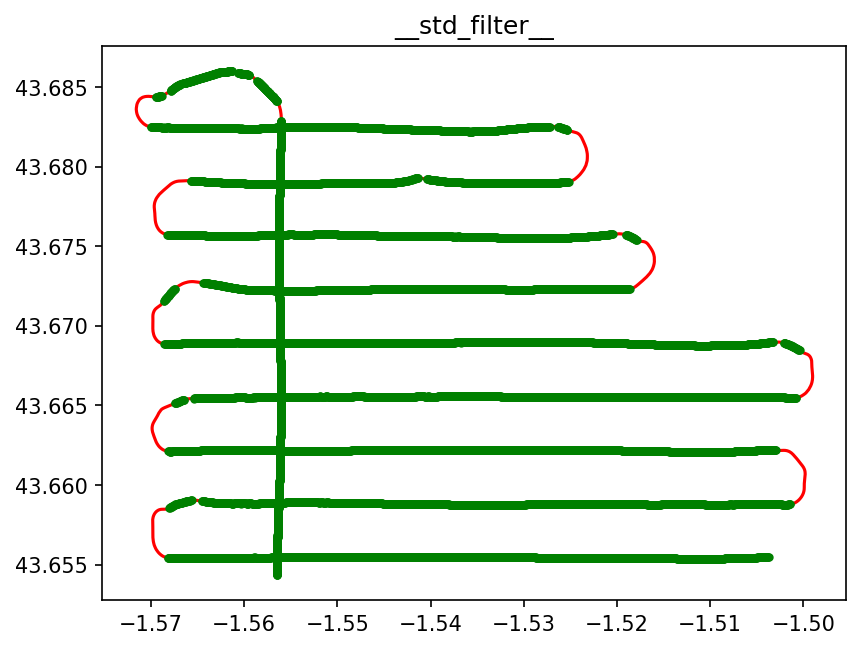

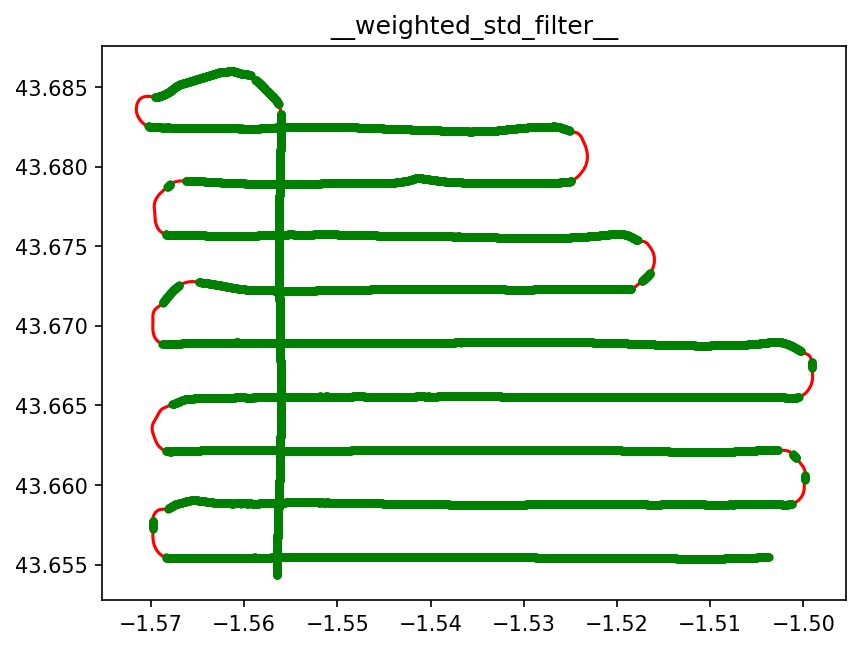

In [94]:
importlib.reload(tf)

%time mask = tf.__std_filter__(nvi[variable].to_series(), period_in_seconds=30, threshold=4)
plot_result('__std_filter__', nvi.where(mask.values))

%time mask = tf.__weighted_std_filter__(nvi[variable].to_series(), period_in_seconds=30, threshold=4)
plot_result('__weighted_std_filter__', nvi.where(mask.values))

In [69]:
def weighted_std(values):
    l = len(values)
    idx = np.arange(l)
    middle_idex = (l-1)/2
    weights = 1 - (abs(idx - middle_idex)/midle_idex)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return math.sqrt(variance)

values = np.array([1,2,1,2,4,2,5,8])
print('weighted_std = ', weighted_std(values), ' ; std = ' , np.std(values))

values = np.array([1,2,5,8,4,2,2,1])
print('weighted_std = ', weighted_std(values), ' ; std = ' , np.std(values))



weighted_std =  1.5857643070456593  ; std =  2.2603926650031405
weighted_std =  2.3599440538919563  ; std =  2.2603926650031405


In [126]:
values = np.array([3,2,1,2,4,1,2,5,6])
l = len(values)
print(l/2)
[(n+1 if n < l/2 else (l-n))/math.ceil(l/2) for n in range(l)]

4.5


[0.2, 0.4, 0.6, 0.8, 1.0, 0.8, 0.6, 0.4, 0.2]

In [175]:
values = np.array([3,2,1,2,4,1,2,5,6,5,7])
l = len(values)
print(l)
a = np.arange(1, 1+ l/2)
weights = np.concatenate([a,np.flip(a)]) if l % 2 == 0  else np.concatenate([a,np.flip(a[:-1])])
print(weights, len(weights))

11
[1. 2. 3. 4. 5. 6. 5. 4. 3. 2. 1.] 11


In [59]:
values = np.array([3,2,1,2,4,1,2,5,3])
l = len(values)
idx = np.arange(l)
middle_idex = (l-1)/2
weights = 1 - (abs(idx - middle_idex)/midle_idex)

In [39]:
dft = pd.DataFrame(
    {"A": [0, 1, 2, 3, 4, 5]},
    index=pd.Index(
        [
            pd.Timestamp("20130101 09:00:00"),
            pd.Timestamp("20130101 09:00:02"),
            pd.Timestamp("20130101 09:00:03"),
            pd.Timestamp("20130101 09:00:05"),
            pd.Timestamp("20130101 09:00:06"),
            pd.Timestamp("20130101 09:00:07"),
        ],
        name="foo",
    ),
)
dft.rolling("2S", center=True).apply(lambda x: len(x))

A
foo                     
2013-01-01 09:00:00  1.0
2013-01-01 09:00:02  2.0
2013-01-01 09:00:03  1.0
2013-01-01 09:00:05  2.0
2013-01-01 09:00:06  2.0
2013-01-01 09:00:07  1.0

In [73]:
# parameters
period = '30S'

nvi = read_nvi(base_file)
nvi_resample = nvi.resample(time=period).first()

def plot_result(title, result):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.plot(nvi.lon, nvi.lat, c='r')
    #ax.plot(nvi_resample.lon, nvi_resample.lat, '|y')
    ax.plot(result.lon, result.lat, '.g')
    
def filtering_with_rolling(variable, period, threshold, plot = True):
    log = f'filtering_with_rolling : var = {variable.name} ; period = {period} ; threshold = {threshold}'
    print(log)
    std = variable.rolling(time=period, center=True, min_periods =1).std()
    mask = std > threshold
    if plot :
        plot_result(log, nvi.where(mask))
    return mask

def filtering_with_rolling_pd(variable, period, threshold, plot = True):
    log = f'filtering_with_rolling_pd : var = {variable.name} ; period = {period} ; threshold = {threshold}'
    print(log)
    std = variable.to_series().rolling(period, center=True, min_periods=1).std().to_xarray()
    mask = std > threshold
    if plot :
        plot_result(log, nvi.where(mask))
    return mask
    
def filtering_with_resampling_reindexing(variable, period, threshold, method='ffill', plot = True):
    log = f'filtering_with_resampling_reindexing : var = {variable} ; period = {period} ; threshold = {threshold} ; method = {method}'
    print(log)
    resampled_std = variable.resample(time=period).std()
    std = resampled_std.reindex_like(nvi, method)
    mask = std > threshold
    if plot :
        plot_result(log, nvi.where(mask))
    return mask


# filter on heading
variable = 'heading'
threshold = 4
#%time filtering_with_rolling(variable, 60, threshold)
%time result = filtering_with_rolling_pd(nvi[variable], period, threshold)
#%time filtering_with_resampling_reindexing(variable, period, threshold)

# filter on speed
#variable = 'speed'
#threshold = 0.1
#%time filtering_with_rolling(variable, 60, threshold)
#%time filtering_with_rolling_pd(variable, period, threshold)
#%time filtering_with_resampling_reindexing(variable, period, threshold)

AttributeError: module 'pytechsas.sensor.turn_filter' has no attribute '__weighted_std_filter__'

filtering_with_rolling_pd : var = heading ; period = 30S ; threshold = 4


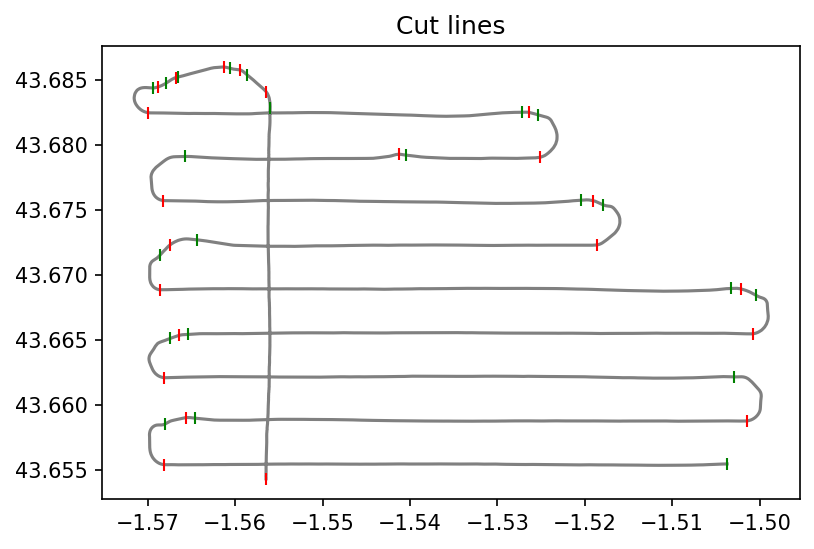

In [242]:
file = "F://04_globe_formation//sedymaq//nvi//output_merge.nvi"
nvi_ds = read_nvi(file)
result = filtering_with_rolling_pd(nvi_ds['heading'], '30S', 4, False)
#cut_points = result.to_series().diff().to_xarray().where(True)
cumsum = result.cumsum()
groups = result.groupby(cumsum)

lines = []
index = 1
for name, group in groups:
    if group.count() > 1:
        lines.append(f'Line {index} : {group.time[0].values} to {group.time[-1].values}')
        index+=1

#filtered_lines = lines.where(lines.count() > 1)
#print(f'result : {result.size}')
#print(f'lines : {lines}')
#print(f'line counts : {lines.count()}')
#print(f'filtered lines : {lines.first().where(lines.count() > 1, drop=True)}\n\n')


result_s = result.to_series()
result_s.groupby(result_s.cumsum()).first() #filter(lambda g : g.count()  == 1)

diff = result_s.diff()
diff[0] = True
diff2 = result_s.diff(-1)

filter_by_diff = result_s[(diff|diff2)&(~result_s)]

straight_line = ~result_s

# get starts
diff_with_previous = straight_line.diff()
diff_with_previous[0] = True
starts = diff_with_previous & straight_line

#get ends
diff_with_next = result_s.diff(-1)
diff_with_next[-1] = True
ends = diff_with_next & straight_line

starts_nav = nvi_ds.where(starts.to_xarray())
ends_nav = nvi_ds.where(ends.to_xarray())
fig, ax = plt.subplots()
ax.set_title('Cut lines')
ax.plot(nvi.lon, nvi.lat, c='gray')
ax.plot(starts_nav.lon, starts_nav.lat, '|g')
ax.plot(ends_nav.lon, ends_nav.lat, '|r')

In [167]:
def plot_lines(nvi_ds, lines):
    fig, ax = plt.subplots()
    ax.set_title("Cut lines")
    ax.plot(nvi_ds.lon, nvi_ds.lat, 'r')
    filtered_nvi = nvi_ds.where(lines)
    ax.plot(filtered_nvi.lon, filtered_nvi.lat, 'g')
    
def std_filter(variable, period, threshold):
    print(f'Apply filter on {variable.name} : period = {period} ; threshold = {threshold}')
    std = variable.to_series().rolling(period, center=True, min_periods=1).std()
    return std < threshold

def compute_cut_lines(file: str, 
                      heading_period:str = None,
                      heading_threshold: float = None,
                      speed_period:str = None,
                      speed_threshold: float = None,
                      minimum_duration_min: float = None):
    nvi_ds = read_nvi(file)

    print(f'Compute cut line for file : {file} (size: {len(nvi_ds.time)})') 
    # find straight line (mask : 1 == straight line; 0 == turn)
    straight_line = None
    if heading_period and heading_threshold:
        straight_line = std_filter(nvi_ds['heading'], heading_period, heading_threshold)
        print(f'Remaning points after heading filter = {straight_line.value_counts()[1]}')
    if speed_period and speed_threshold:
        filtered_from_speed =  std_filter(nvi_ds['speed'], speed_period, speed_threshold)
        straight_line = filtered_from_speed if straight_line is None else (straight_line & filtered_from_speed)
        print(f'Remaning points after speed filter = {straight_line.value_counts()[1]}')
    if straight_line is None:
        print('Bad parameters : heading or speed period/threshold must be specify.')
        return

    #plot_lines(nvi_ds, straight_line.to_xarray())
    
    # get line starts
    diff_with_previous = straight_line.diff()
    diff_with_previous[0] = True
    starts = straight_line[diff_with_previous & straight_line]
    
    #get line ends
    diff_with_next = straight_line.diff(-1)
    diff_with_next[-1] = True
    ends = straight_line[diff_with_next & straight_line]
    
    # build dataframe, and compute
    df = pd.DataFrame(data={'start': starts.index, 'end': ends.index, 'duration': ends.index- starts.index})
    
    # apply filter
    if minimum_duration_min :
        df = df[df.duration > np.timedelta64(minimum_duration_min,'m')]
    return df

def export_to_cut_file(cut_lines_df, output_file_path):
    # create column with index 
    cut_lines_df['index'] = range(1, len(cut_lines_df) + 1) 
    
    # compute string rows 
    data_formater = lambda date_time : date_time.strftime('%d/%m/%Y %H:%M:%S.%f')[:-3]
    cut_lines = cut_lines_df.to_string(header=False, index=False, columns=['start', 'end', 'index'], 
                       formatters={'start': lambda start : '> '+ data_formater(start) ,
                                   'end':data_formater, 'index': lambda idx: f'Line_{idx}'})

    # save in output file
    with open(output_file_path, "w", encoding="utf-8") as f:
        f.write(cut_lines)
        f.flush()

#file = "F://04_globe_formation//sedymaq//nvi//output_merge.nvi"
file = "C://Users//gbillant//Desktop//GLOBE//gravi//03 dataset//14000800_SALSA-LEG1//tests2//201400080055.nvi"
compute_cut_lines(file, '30S', 4, speed_period='30S', speed_threshold=1, minimum_duration_min=5)
#compute_cut_lines(file, speed_period='30S', speed_threshold=0.15, minimum_duration_min=20)
#export_to_cut_file(df, "F://04_globe_formation//sedymaq//nvi//test.cut")
#df_2 = compute_cut_lines("C://Users//gbillant//Desktop//GLOBE//gravi//03 dataset//14000800_SALSA-LEG1//tests2//201400080055.nvi")
#export_to_cut_file(df_2, "F://04_globe_formation//sedymaq//nvi//test_2.cut")

Compute cut line for file : C://Users//gbillant//Desktop//GLOBE//gravi//03 dataset//14000800_SALSA-LEG1//tests2//201400080055.nvi (size: 2545621)
Apply filter on heading : period = 30S ; threshold = 4
Remaning points after heading filter = 2059881
Apply filter on speed : period = 30S ; threshold = 1
Remaning points after speed filter = 2059209


start                 end        duration
4    2014-04-05 02:36:30 2014-04-05 02:44:57 0 days 00:08:27
5    2014-04-05 02:45:18 2014-04-05 02:59:55 0 days 00:14:37
6    2014-04-05 03:00:22 2014-04-05 05:37:17 0 days 02:36:55
7    2014-04-05 05:37:24 2014-04-05 12:12:01 0 days 06:34:37
23   2014-04-05 12:36:28 2014-04-05 13:27:05 0 days 00:50:37
...                  ...                 ...             ...
4758 2014-05-03 08:55:52 2014-05-03 09:16:16 0 days 00:20:24
4762 2014-05-03 09:24:50 2014-05-03 09:35:40 0 days 00:10:50
4764 2014-05-03 09:36:39 2014-05-03 09:57:09 0 days 00:20:30
4785 2014-05-03 10:15:06 2014-05-03 10:20:23 0 days 00:05:17
4786 2014-05-03 10:20:53 2014-05-03 10:43:21 0 days 00:22:28

[705 rows x 3 columns]

In [113]:
nvi_ds
test = pd.Series(True, index=nvi_ds.time)
test

2012-06-07 06:36:35.003000064    True
2012-06-07 06:36:36.003000064    True
2012-06-07 06:36:37.003000064    True
2012-06-07 06:36:38.003000064    True
2012-06-07 06:36:39.003000064    True
                                 ... 
2012-06-07 10:16:20.003000064    True
2012-06-07 10:16:21.003000064    True
2012-06-07 10:16:22.003000064    True
2012-06-07 10:16:23.003000064    True
2012-06-07 10:16:24.003000064    True
Length: 13190, dtype: bool

In [120]:
s1 = pd.Series(True, index=range(10))
s2 = pd.Series(True, index=range(10))
s2[3:7] = False
s1 & s2

0     True
1     True
2     True
3    False
4    False
5    False
6    False
7     True
8     True
9     True
dtype: bool

In [62]:
def std_filter(variable, period, threshold):
    std = variable.to_series().rolling(period, center=True, min_periods=1).std().to_xarray()
    return std > threshold

def compute_cut_lines(file):
    print(f'Open file : {file}')
    nvi_ds = read_nvi(file)

    # find turns, point is in turn if heading std > threshold on period
    print(f'Compute mask...')
    mask = %time std_filter(nvi_ds['heading'], '30S', 5) # mask : 1 == turn

    # groupby with cumsum allows to retrieve lines in same groups 
    print(f'Compute groups (mask size : {mask.size})...')
    groups =  %time mask.groupby(mask.cumsum())
   
    # print lines
    print(f'Print (groups: {len(groups)})...')
    lines = []
    index = 1
    for name, group in groups:
        if group.count() > 1:
            lines.append(f'Line {index} : {group.time[0].values} to {group.time[-1].values}')
            index+=1
    return lines


%time compute_cut_lines("F://04_globe_formation//sedymaq//nvi//output_merge.nvi")



#%time compute_cut_lines("C://Users//gbillant//Desktop//GLOBE//gravi//03 dataset//14000800_SALSA-LEG1//tests2//201400080055_3s.nvi")

Open file : F://04_globe_formation//sedymaq//nvi//output_merge.nvi


NameError: name 'read_nvi' is not defined

In [17]:
importlib.reload(tf)

#file = "F://04_globe_formation//sedymaq//nvi//output_merge.nvi"
#file = "C://Users//gbillant//Desktop//GLOBE//gravi//03 dataset//14000800_SALSA-LEG1//tests2//201400080055.nvi"
file = "C://Users//gbillant//Desktop//GLOBE//gravi//03 dataset//14000800_SALSA-LEG1//test3//201400080045-KSS-AT_KSS31M_cut.gravi.nc"
output_file = "F://04_globe_formation//sedymaq//nvi//15h28.cut"

r =tf.apply_filter(i_path=file,heading_period=30, heading_threshold=4, speed_period=30, speed_threshold=1, 
                minimum_duration=5, o_cut_file=None, save_in_input_file=True)


Open and read input file : C://Users//gbillant//Desktop//GLOBE//gravi//03 dataset//14000800_SALSA-LEG1//test3//201400080045-KSS-AT_KSS31M_cut.gravi.nc
Filter on heading : period: 30 seconds; standard deviation threshold: 4
26208 data filtered
Filter on speed : period: 30 seconds; standard deviation threshold: 1
25 data filtered
Save in file : C://Users//gbillant//Desktop//GLOBE//gravi//03 dataset//14000800_SALSA-LEG1//test3//201400080045-KSS-AT_KSS31M_cut.gravi_filt.nc


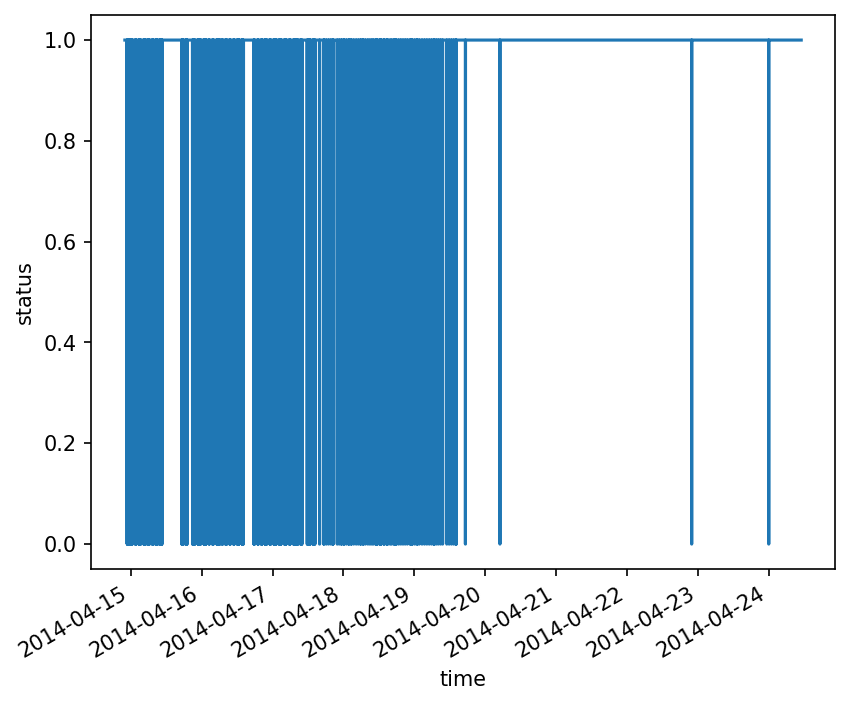

In [50]:
r.status.plot()
r = r.drop_vars('measureTS')
r.to_netcdf("C://Users//gbillant//Desktop//GLOBE//gravi//03 dataset//14000800_SALSA-LEG1//test3//from_notebook3.nc")

In [51]:
r

<xarray.Dataset>
Dimensions:   (time: 412327)
Coordinates:
  * time      (time) datetime64[ns] 2014-04-14T22:00:41.965632512 ... 2014-04...
Data variables: (12/14)
    datation  (time) float32 ...
    bouguer   (time) float32 ...
    seastate  (time) float32 ...
    freeair   (time) float32 ...
    acY       (time) float32 ...
    acX       (time) float32 ...
    ...        ...
    lon       (time) float64 ...
    lat       (time) float64 ...
    heading   (time) float64 ...
    speed     (time) float64 ...
    altitude  (time) float64 ...
    status    (time) bool True True True True True ... True True True True True
Attributes: (12/25)
    history:                       Tue Jul 22 14:46:51 2014: /home/coriolis_e...
    source:                        Acquisition of KSS31M
    conventions:                   CF-1.0.
    creationtime:                  2014-04-04T22:00:41Z
    device_firstusedate:           2000-01-01T00:00:00Z
    device_deviceid:               AT_KSS31M_01
    ...                            ...
    frame_sourcetype:              gravi
    frame_period:                  1.0
    title:                         Technical and Scientific sensors Acquisiti...
    institution:                   IFR
    reference:                     http://www.ifremer.fr
    nco_openmp_thread_number:      1

In [42]:
file = "C://Users//gbillant//Desktop//GLOBE//gravi//03 dataset//14000800_SALSA-LEG1//test3//201400080045-KSS-AT_KSS31M_cut.gravi.nc"
importlib.reload(tf)
r =tf.apply_filter(i_path=file,heading_period=30, heading_threshold=4, speed_period=30, speed_threshold=1, 
                minimum_duration=5, o_cut_file=None, save_in_input_file=True)

Open and read input file : C://Users//gbillant//Desktop//GLOBE//gravi//03 dataset//14000800_SALSA-LEG1//test3//201400080045-KSS-AT_KSS31M_cut.gravi.nc
Filter on heading : period: 30 seconds; standard deviation threshold: 4
26208 data filtered
Filter on speed : period: 30 seconds; standard deviation threshold: 1
25 data filtered
Save in input file


In [15]:
import numpy as np
a = np.array([0,3,6,9,12,15,18,21,24,27,30])
print(a.std(), a.mean(), a.min(), a.max(), a.max()/a.std())


9.486832980505138 15.0 0 30 3.162277660168379


In [12]:
filtered_ds.close()

<xarray.Dataset>
Dimensions:    (time: 412327)
Coordinates:
    measureTS  (time) datetime64[ns] ...
  * time       (time) datetime64[ns] 2014-04-14T22:00:41.965632512 ... 2014-0...
Data variables: (12/14)
    datation   (time) float32 ...
    bouguer    (time) float32 ...
    seastate   (time) float32 ...
    freeair    (time) float32 ...
    acY        (time) float32 ...
    acX        (time) float32 ...
    ...         ...
    lon        (time) float64 ...
    lat        (time) float64 ...
    heading    (time) float64 ...
    speed      (time) float64 ...
    altitude   (time) float64 ...
    status     (time) bool ...
Attributes: (12/25)
    history:                       Tue Jul 22 14:46:51 2014: /home/coriolis_e...
    source:                        Acquisition of KSS31M
    conventions:                   CF-1.0.
    creationtime:                  2014-04-04T22:00:41Z
    device_firstusedate:           2000-01-01T00:00:00Z
    device_deviceid:               AT_KSS31M_01
    ... 

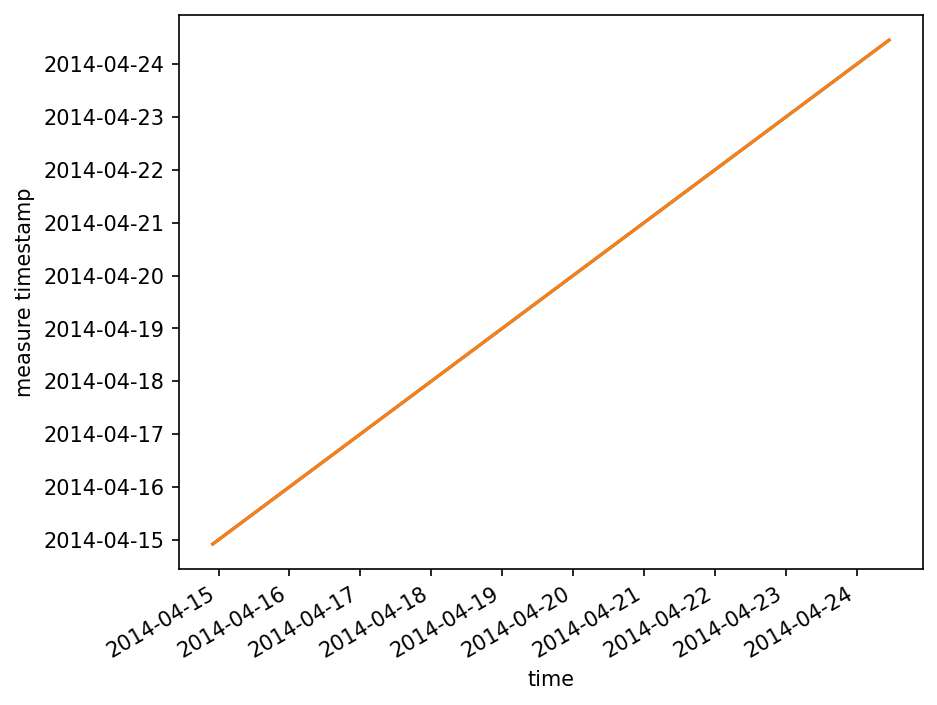

In [11]:
file = "C://Users//gbillant//Desktop//GLOBE//gravi//03 dataset//14000800_SALSA-LEG1//test3//201400080045-KSS-AT_KSS31M_cut.gravi.nc"
with xr.open_dataset(file.replace(".nc","_filtered2.nc")) as filtered_ds:
    filtered_ds
print(filtered_ds)
print(ds)
ds.measureTS.plot()
filtered_ds.measureTS.plot()